In [24]:
import numpy as np
import pandas as pd
from scipy.stats import norm as normal, binom
import bplot as bp
from scipy.optimize import minimize
from scipy.special import loggamma
import patsy
import multiprocessing
from joblib import Parallel, delayed

In [22]:
def ll_normal(beta, yX):
    y = yX[:, 0]
    X = yX[:, 1:]
    N = X.shape[0]
    mu = np.full(N, np.nan)
    for n in range(N):
        mu[n] = np.sum(X[n, :] * beta)
        
    d = y - mu
    return np.sum(d*d)

def optim(data, initval = None):
    k = data.shape[1]-1
    return minimize(ll_normal, (initval if initval else np.random.normal(size = k)), args=(data), method="BFGS")["x"]

def bootstrap(data, R, fun, jobs=None):
    if jobs is None or jobs < 1:
        jobs = multiprocessing.cpu_count()
    N, k = data.shape
    k -= 1
    thetas = np.full((R, k), np.nan)
    thetas[:, :] = Parallel(n_jobs=jobs)(delayed(fun)(data[np.random.choice(N, N, replace=True), :]) for r in range(R))
    return thetas

# 14 November 2019

Going to be looking at a new data set using elmhurst data

www.github.com/roualdes/data/blob/master/elmhurst.txt

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/roualdes/data/master/elmhurst.csv")

We are going to practice **Simple Linear Regression** using this new data set. We will focus on the Family income and gift aid (both in thousands of dollars) variables.

Family income is going to be the explanatory variable with our intuition explaining that the more a family makes, the less aid they will receive.

Gift aid will be our response variable.
$$Y_n\sim N(\mu_n,\sigma^2)$$
$$\mu_n=\beta_0+\beta_1*x_n$$

In [13]:
df.head()

,family_income,gift_aid,price_paid
0,92.922,21.72,14.28
1,0.250,27.47,8.53
2,53.092,27.75,14.25
3,50.200,27.22,8.78
4,137.613,18.00,24.00


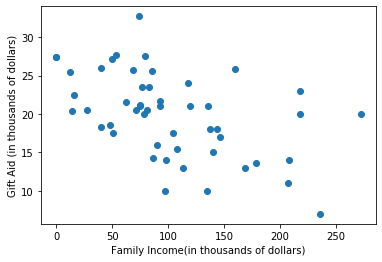

In [15]:
#make a plot
bp.point(df["family_income"], df["gift_aid"])
bp.labels(x="Family Income(in thousands of dollars)", y="Gift Aid (in thousands of dollars)")

In [19]:
X = patsy.dmatrix("~ family_income", data=df)
yX = np.c_[df["gift_aid"], X]

In [29]:
betahat = optim(yX)
print(betahat)

[24.31933182 -0.04307168]


### For the intercept:
If a family made 0 dollars, we can estimate that they would receive 24.32 (times 1000) dollars.

### For the slope:
For every thousand dollars a family makes, we can estimate that they would receive 0.04 (times 1000) less aid.

### Formula:
$$\mu_n=\beta_0+\beta_1*x_n$$
$$\mu_n=24.32 -0.043*x_n$$

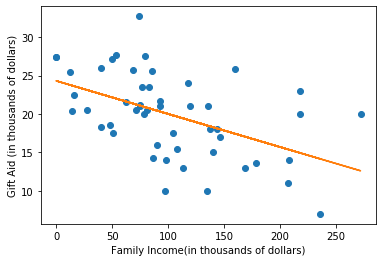

In [30]:
#We can actually add the line of best fit
bp.point(df["family_income"], df["gift_aid"])
bp.labels(x="Family Income(in thousands of dollars)", y="Gift Aid (in thousands of dollars)")
bp.line(df['family_income'], betahat[0] + betahat[1] * df['family_income'], color = bp.color[1])

In [36]:
#Family earns $100,000 in income: What do we predict they would receive in income?
income = 100

print(betahat[0] + betahat[1]*income)
print(np.sum(betahat * np.asarray([1,100])))

20.012163857496397
20.012163857496397


This states that if a family earns 100,000 dollars, they can expect to receive 20,012 dollars in aid.

In [25]:
betas = bootstrap(yX, 1001, optim)

In [59]:
percentiles = np.percentile(betas, [10,90], axis=0)
percentiles

array([[22.8137098 , -0.05933323],
       [25.77426434, -0.02859292]])

"We are 80% confident that if a family did not earn any income, we can expect the aid they receive is between 22.81 thousands of dollars and 25.77 thousands of dollars"  
"We are 80% confident that for every extra thousand dollars a family earns, we can expect the aid to receive to decrease between 0.02 and 0.05 thousands of dollars"

## Get a confidence interval of how much a family could expect to receive in gift aid if their income is 100 (in thousands of dollars)

## For loop implementation:

In [62]:
R=1001
gifthataid = np.full(R, np.nan)
for r in range(R):
    gifthataid[r] = np.sum(np.asarray([1,100]) * betas[r, :])

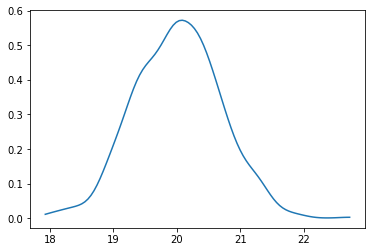

In [65]:
bp.density(gifthataid)

In [66]:
np.percentile(gifthataid, [10,90])

array([19.15986219, 20.87536983])

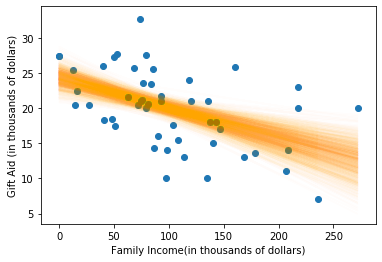

In [69]:
#Add our betas
for r in range(R):
    bp.line(df['family_income'], betas[r,0] + betas[r,1]*df['family_income'], color = "orange", alpha=0.01)
bp.point(df["family_income"], df["gift_aid"])
bp.labels(x="Family Income(in thousands of dollars)", y="Gift Aid (in thousands of dollars)")

In [67]:
print(np.sum(percentiles * np.asarray([1,100]), axis=1))

[16.88038703 22.91497222]


"We are 80% confident that if a family earned 100 thousands of dollars, they would receive between 16.88 and 22.91 thousands of dollars in gift aid."